In [1]:
import string
from itertools import product

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc3 as pm
import seaborn as sns
from numpy.random import exponential, normal

In [2]:
import warnings

warnings.simplefilter(action="ignore", category=UserWarning)

In [3]:
gg.theme_set(gg.theme_minimal())

In [4]:
RANDOM_SEED = 103

---

## Model 4. Multiple genes and multiple cell lines hierarchical model with one covariate

Model the logFC of multiple genes in multiple cell lines using a single predictor: RNA expression.
A hierarchcial model will be used to pool information across genes and cell lines.
Also, to better mimic real data, I have added in the fact that there are multiple measures of logFC for each gene, but only one measure for RNA expression.

$
logFC_{g,c} \sim Normal(\mu_{g,c}, \sigma) \\
\quad \mu_g = \alpha_g + \gamma_c + \beta_g R \\
\qquad \alpha_g \sim \mathcal{N}(\mu_\alpha, \sigma_\alpha) \\
\qquad \quad \mu_\alpha \sim \mathcal{N}(0, 5) \quad \sigma_\alpha \sim \text{Exp}(1) \\
\qquad \gamma_c \sim \mathcal{N}(\mu_\gamma, \sigma_\gamma) \\
\qquad \quad \mu_\gamma \sim \mathcal{N}(0, 5) \quad \sigma_\gamma \sim \text{Exp}(1) \\
\qquad \beta_g \sim \mathcal{N}(\mu_\beta, \sigma_\beta) \\
\qquad \quad \mu_\beta \sim \mathcal{N}(0, 2) \quad \sigma_\beta \sim \text{Exp}(1) \\
\quad \sigma \sim \text{Exp}(1)
$


Simulated values:

- number of cell lines: 20
- number of genes: 5
- number of repeated measures: 3
- $\mu_\alpha = -1$, $\sigma_\alpha = 1$
- $\mu_\gamma = 0$, $\sigma_\gamma = 3$
- $\mu_\beta = -1$, $\sigma_\beta = 2$
- $\sigma = 0.3$

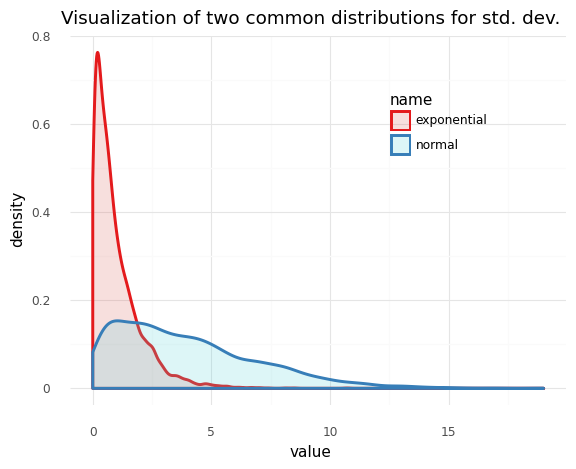

<ggplot: (8741728299240)>

In [5]:
N = 5000
np.random.seed(0)
sigma_dists = pd.DataFrame(
    {
        "name": np.repeat(["normal", "exponential"], N),
        "value": np.concatenate(
            [np.abs(np.random.normal(0, 5, N)), np.random.exponential(1, N)]
        ).flatten(),
    }
)

(
    gg.ggplot(sigma_dists, gg.aes("value"))
    + gg.geom_density(gg.aes(color="name", fill="name"), alpha=0.2, size=1.2)
    + gg.scale_color_brewer(type="qual", palette="Set1")
    + gg.theme(legend_position=(0.7, 0.7))
    + gg.labs(title="Visualization of two common distributions for std. dev.")
)

In [6]:
np.random.seed(RANDOM_SEED)

# Real data parameters.
num_genes = 5
num_cell_lines = 20
num_logfc_datum = 3

# Real model values.
real_mu_alpha, real_sigma_alpha = -1, 1
real_mu_gamma, real_sigma_gamma = 0, 3
real_mu_beta, real_sigma_beta = -1, 2
real_sigma = 0.3

genes = ["gene" + a for a in string.ascii_uppercase[:num_genes]]
gene_idx = list(range(num_genes))

cell_lines = ["cell" + a for a in string.ascii_uppercase[:num_cell_lines]]
cell_line_idx = list(range(num_cell_lines))

# Sample from real distributions for the rest of the model parameters.
real_alpha_g = np.random.normal(real_mu_alpha, real_sigma_alpha, num_genes)
real_gamma_c = np.random.normal(real_mu_gamma, real_sigma_gamma, num_cell_lines)
real_beta_g = np.random.normal(real_mu_beta, real_sigma_beta, num_genes)

rna_data = pd.DataFrame(list(product(genes, cell_lines)), columns=["gene", "cell_line"])

# RNA data (scaled by gene).
rna_data["rna"] = np.random.normal(0, 1, len(rna_data))

for c in ["gene", "cell_line"]:
    rna_data[c] = pd.Categorical(rna_data[c])

logfc_data = []
for i in range(num_logfc_datum):
    x = rna_data.copy()
    x["sgrna_idx"] = i
    logfc_data.append(x)

logfc_data = pd.concat(logfc_data).reset_index(drop=True)

logfc_data["logfc"] = np.nan
for i in range(len(logfc_data)):
    gene_i = logfc_data["gene"].cat.codes[i]
    cell_line_i = logfc_data["cell_line"].cat.codes[i]
    mu = (
        real_alpha_g[gene_i]
        + real_gamma_c[cell_line_i]
        + real_beta_g[gene_i] * logfc_data.loc[i, "rna"]
    )
    logfc_data.loc[i, "logfc"] = np.random.normal(mu, real_sigma)

logfc_data

,gene,cell_line,rna,sgrna_idx,logfc
0,geneA,cellA,-1.187443,0,7.516370
1,geneA,cellB,0.299138,0,-1.184598
2,geneA,cellC,-0.947764,0,1.945419
3,geneA,cellD,-1.843382,0,-0.861100
4,geneA,cellE,0.810589,0,-6.491923
...,...,...,...,...,...
295,geneE,cellP,1.219362,2,0.194254
296,geneE,cellQ,-0.840481,2,-5.967522
297,geneE,cellR,0.607882,2,-0.719954
298,geneE,cellS,0.429605,2,1.885927


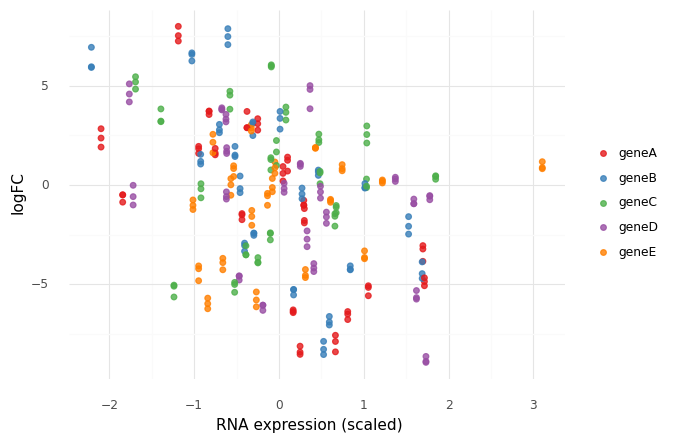

<ggplot: (8741728299123)>

In [7]:
(
    gg.ggplot(logfc_data, gg.aes(x="rna", y="logfc", color="gene"))
    + gg.geom_point(size=1.8, alpha=0.8)
    + gg.scale_color_brewer(type="qual", palette="Set1")
    + gg.labs(x="RNA expression (scaled)", y="logFC", color="")
)

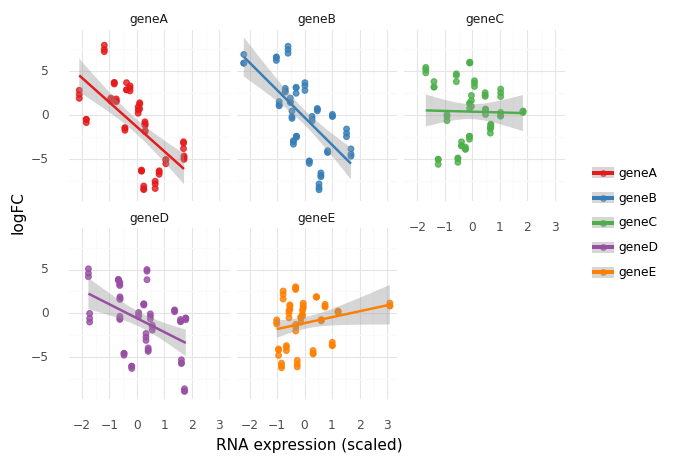

<ggplot: (8741725996894)>

In [8]:
(
    gg.ggplot(logfc_data, gg.aes(x="rna", y="logfc", color="gene"))
    + gg.facet_wrap("gene", nrow=2)
    + gg.geom_point(size=1.8, alpha=0.8)
    + gg.geom_smooth(method="lm")
    + gg.scale_color_brewer(type="qual", palette="Set1")
    + gg.labs(x="RNA expression (scaled)", y="logFC", color="")
)

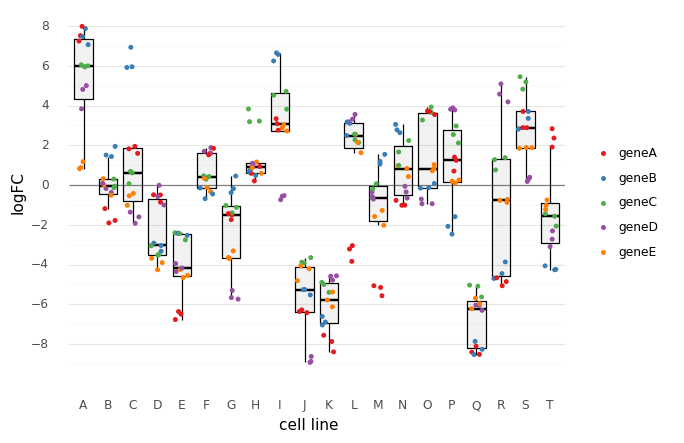

<ggplot: (8741724230611)>

In [9]:
(
    gg.ggplot(logfc_data, gg.aes(x="cell_line", y="logfc"))
    + gg.geom_hline(yintercept=0, color="gray")
    + gg.geom_boxplot(color="black", fill="black", alpha=0.05, outlier_color="")
    + gg.geom_jitter(gg.aes(color="gene"), width=0.3, size=1)
    + gg.scale_color_brewer(type="qual", palette="Set1")
    + gg.scale_x_discrete(labels=[a.replace("cell", "") for a in cell_lines])
    + gg.scale_y_continuous(breaks=range(-16, 16, 2))
    + gg.theme(panel_grid_major_x=gg.element_blank())
    + gg.labs(x="cell line", y="logFC", color="")
)

In [10]:
gene_idx = logfc_data["gene"].cat.codes.to_list()
cell_line_idx = logfc_data["cell_line"].cat.codes.to_list()

with pm.Model() as model4:
    # Hyper-priors
    mu_alpha = pm.Normal("mu_alpha", 0, 2)
    sigma_alpha = pm.Exponential("sigma_alpha", 1)
    mu_gamma = pm.Normal("mu_gamma", 0, 2)
    sigma_gamma = pm.Exponential("sigma_gamma", 1)
    mu_beta = pm.Normal("mu_beta", 0, 1)
    sigma_beta = pm.Exponential("sigma_beta", 1)

    # Priors
    alpha_g = pm.Normal("alpha_g", mu_alpha, sigma_alpha, shape=num_genes)
    gamma_c = pm.Normal("gamma_c", mu_gamma, sigma_gamma, shape=num_cell_lines)
    beta_g = pm.Normal("beta_g", mu_beta, sigma_beta, shape=num_genes)
    mu_gc = pm.Deterministic(
        "mu_gc",
        alpha_g[gene_idx] + gamma_c[cell_line_idx] + beta_g[gene_idx] * logfc_data.rna,
    )
    sigma = pm.Exponential("sigma", 1)

    # Likelihood
    logfc = pm.Normal("logfc", mu=mu_gc, sigma=sigma, observed=logfc_data.logfc)

    # Sampling
    model4_prior_check = pm.sample_prior_predictive(random_seed=RANDOM_SEED)
    model4_trace = pm.sample(2000, tune=2000, random_seed=RANDOM_SEED)
    model4_post_check = pm.sample_posterior_predictive(
        model4_trace, random_seed=RANDOM_SEED
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_g, gamma_c, alpha_g, sigma_beta, mu_beta, sigma_gamma, mu_gamma, sigma_alpha, mu_alpha]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 134 seconds.
The number of effective samples is smaller than 10% for some parameters.


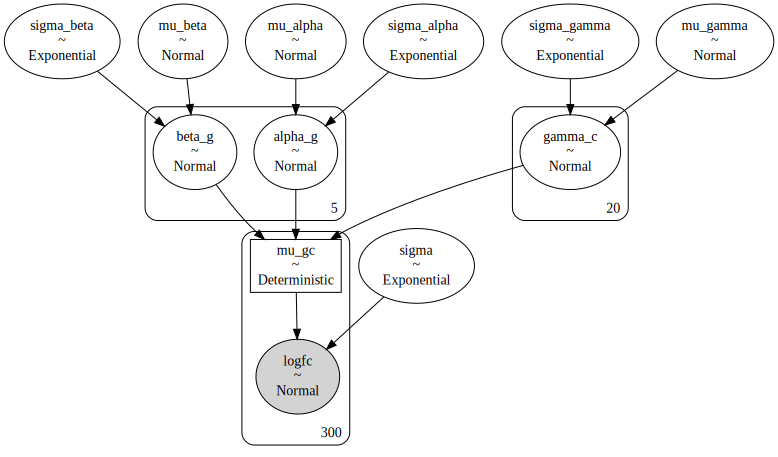

In [11]:
pm.model_to_graphviz(model4)

In [12]:
az_model4 = az.from_pymc3(
    trace=model4_trace,
    prior=model4_prior_check,
    posterior_predictive=model4_post_check,
    model=model4,
)

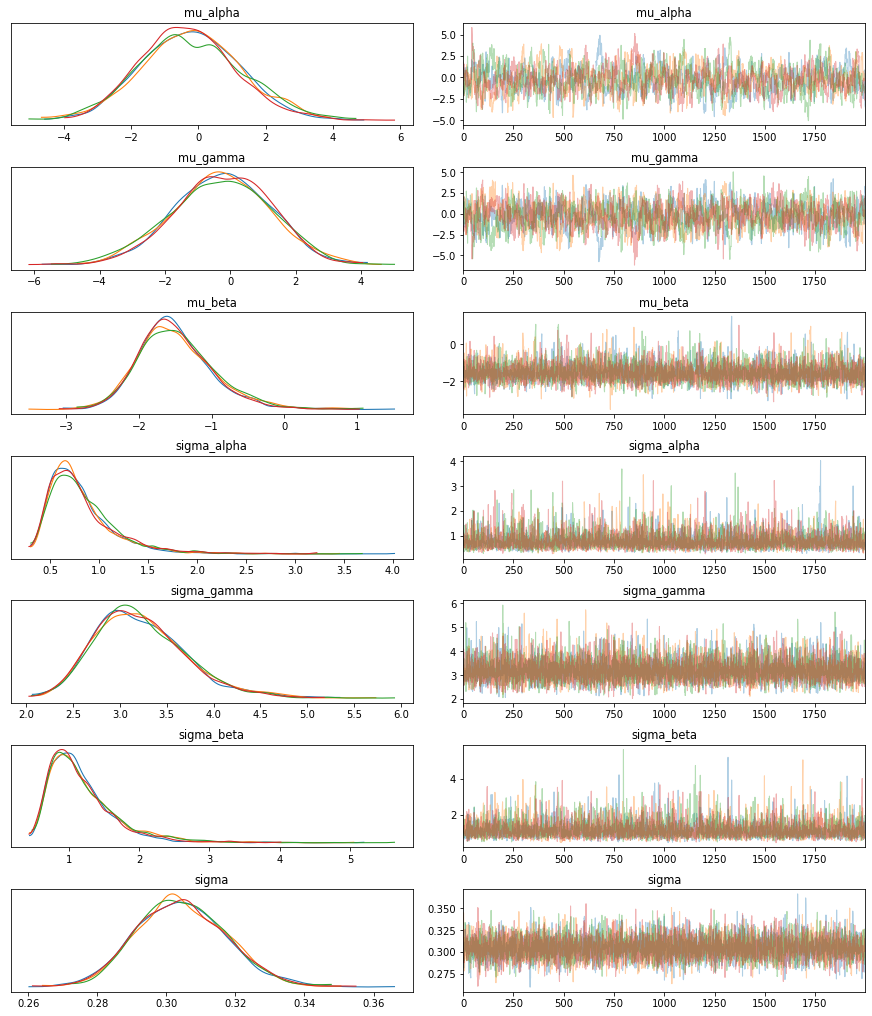

In [13]:
var_names1 = ["mu_" + a for a in ["alpha", "gamma", "beta"]]
var_names2 = ["sigma_" + a for a in ["alpha", "gamma", "beta"]]
az.plot_trace(az_model4, var_names=var_names1 + var_names2 + ["sigma"])
plt.show()

In [14]:
s = az.summary(az_model4, var_names=var_names1 + var_names2)
s["real_values"] = [
    real_mu_alpha,
    real_mu_gamma,
    real_mu_beta,
    real_sigma_alpha,
    real_sigma_gamma,
    real_sigma_beta,
]
s

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat,real_values
mu_alpha,-0.236,1.490,-2.862,2.727,0.057,0.040,679.0,679.0,684.0,970.0,1.0,-1
mu_gamma,-0.263,1.504,-3.135,2.489,0.054,0.038,773.0,773.0,778.0,1216.0,1.0,0
mu_beta,-1.488,0.530,-2.371,-0.408,0.008,0.006,4072.0,4072.0,4804.0,3018.0,1.0,-1
sigma_alpha,0.823,0.353,0.345,1.444,0.006,0.004,3797.0,3351.0,5010.0,4152.0,1.0,1
sigma_gamma,3.225,0.495,2.362,4.157,0.006,0.004,7478.0,6808.0,8396.0,4696.0,1.0,3
sigma_beta,1.188,0.494,0.519,2.086,0.009,0.006,3075.0,3075.0,3877.0,4014.0,1.0,2


I believe that the $\alpha_g$ values were poorly estimated because they do not add much information to the model.
The other parameters fit well, but these have very wide posterior distributions.

In [15]:
az.summary(az_model4, var_names=["alpha_g"]).assign(real_values=real_alpha_g)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat,real_values
alpha_g[0],-1.029,1.504,-3.686,1.963,0.060,0.042,638.0,638.0,642.0,870.0,1.0,-2.249278
alpha_g[1],0.031,1.504,-2.624,3.021,0.059,0.042,639.0,639.0,644.0,853.0,1.0,-1.260331
alpha_g[2],0.658,1.504,-2.013,3.624,0.060,0.042,637.0,637.0,642.0,873.0,1.0,-0.616207
alpha_g[3],-0.135,1.504,-2.805,2.837,0.060,0.042,638.0,638.0,643.0,898.0,1.0,-1.385461
alpha_g[4],-0.733,1.503,-3.480,2.179,0.060,0.042,638.0,638.0,643.0,887.0,1.0,-2.085137


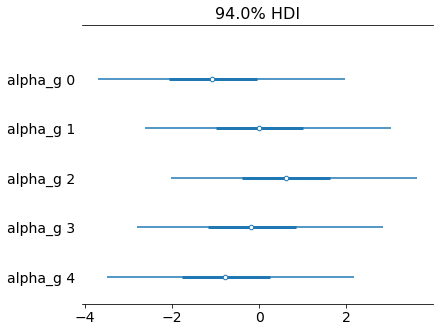

In [16]:
az.plot_forest(az_model4, var_names=["alpha_g"], combined=True)
plt.show()

In [17]:
az.summary(az_model4, var_names=["beta_g"]).assign(real_values=real_beta_g)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat,real_values
beta_g[0],-2.552,0.044,-2.635,-2.471,0.000,0.0,8265.0,8264.0,8261.0,5253.0,1.0,-2.634413
beta_g[1],-2.887,0.048,-2.977,-2.797,0.001,0.0,8937.0,8924.0,8926.0,5093.0,1.0,-2.892255
beta_g[2],-0.563,0.053,-0.664,-0.464,0.001,0.0,7626.0,7581.0,7632.0,5206.0,1.0,-0.558722
beta_g[3],-2.239,0.043,-2.316,-2.156,0.000,0.0,9994.0,9989.0,9991.0,4799.0,1.0,-2.201467
beta_g[4],-1.284,0.047,-1.373,-1.195,0.001,0.0,8608.0,8602.0,8621.0,5191.0,1.0,-1.305132


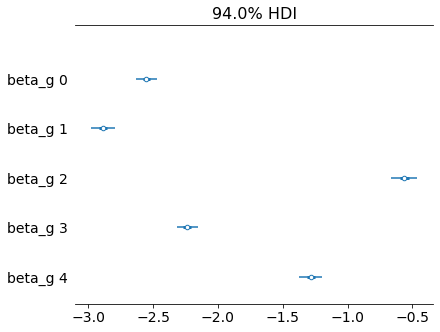

In [18]:
az.plot_forest(az_model4, var_names=["beta_g"], combined=True)
plt.show()

In [19]:
az.summary(az_model4, var_names=["gamma_c"]).assign(real_values=real_gamma_c)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat,real_values
gamma_c[0],5.544,1.506,2.640,8.283,0.060,0.042,638.0,638.0,643.0,861.0,1.00,6.981657
gamma_c[1],0.059,1.506,-2.909,2.742,0.060,0.042,637.0,637.0,642.0,891.0,1.00,1.292379
gamma_c[2],-0.008,1.507,-3.003,2.663,0.060,0.042,637.0,637.0,642.0,879.0,1.00,1.296947
gamma_c[3],-4.226,1.507,-7.124,-1.480,0.060,0.043,640.0,619.0,645.0,864.0,1.00,-2.940034
gamma_c[4],-3.294,1.505,-6.259,-0.611,0.059,0.043,640.0,615.0,645.0,878.0,1.00,-1.895896
gamma_c[5],0.588,1.506,-2.359,3.297,0.060,0.042,638.0,638.0,643.0,882.0,1.00,1.732326
gamma_c[6],-1.565,1.506,-4.520,1.143,0.060,0.043,639.0,614.0,643.0,901.0,1.00,-0.374273
gamma_c[7],1.779,1.505,-1.160,4.495,0.059,0.042,640.0,640.0,645.0,900.0,1.00,2.936844
gamma_c[8],3.398,1.505,0.528,6.183,0.060,0.042,637.0,637.0,642.0,882.0,1.00,4.784765
gamma_c[9],-4.801,1.507,-7.755,-2.091,0.060,0.043,637.0,618.0,642.0,866.0,1.00,-3.605834


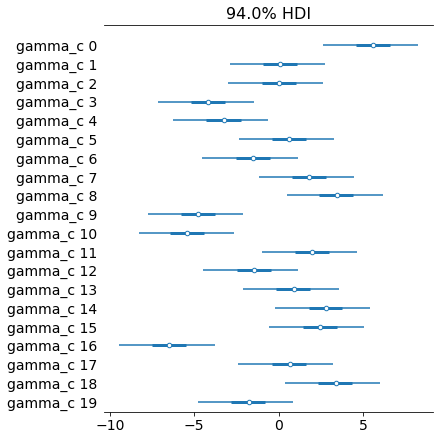

In [20]:
az.plot_forest(az_model4, var_names=["gamma_c"], combined=True)
plt.show()

In [21]:
post_alpha_g = model4_trace.get_values(varname="alpha_g")
post_gamma_c = model4_trace.get_values(varname="gamma_c")
post_beta_g = model4_trace.get_values(varname="beta_g")
post_mu_gc = model4_trace.get_values(varname="mu_gc")

post_mu_mean = post_mu_gc.mean(axis=0)
post_mu_hdi = np.array([az.hpd(x, credible_interval=0.89) for x in post_mu_gc.T])

logfc_post_df = logfc_data.copy()
logfc_post_df["post_logfc"] = post_mu_mean
logfc_post_df["hpi_lower"] = [x[0] for x in post_mu_hdi]
logfc_post_df["hpi_upper"] = [x[1] for x in post_mu_hdi]
logfc_post_df

,gene,cell_line,rna,sgrna_idx,logfc,post_logfc,hpi_lower,hpi_upper
0,geneA,cellA,-1.187443,0,7.516370,7.545749,7.360622,7.728335
1,geneA,cellB,0.299138,0,-1.184598,-1.734134,-1.901040,-1.565145
2,geneA,cellC,-0.947764,0,1.945419,1.381448,1.200534,1.556054
3,geneA,cellD,-1.843382,0,-0.861100,-0.550578,-0.748461,-0.336321
4,geneA,cellE,0.810589,0,-6.491923,-6.392022,-6.570705,-6.222555
...,...,...,...,...,...,...,...,...
295,geneE,cellP,1.219362,2,0.194254,0.130086,-0.058250,0.311695
296,geneE,cellQ,-0.840481,2,-5.967522,-6.197949,-6.377024,-6.023662
297,geneE,cellR,0.607882,2,-0.719954,-0.914031,-1.084077,-0.733961
298,geneE,cellS,0.429605,2,1.885927,2.057659,1.882286,2.221496


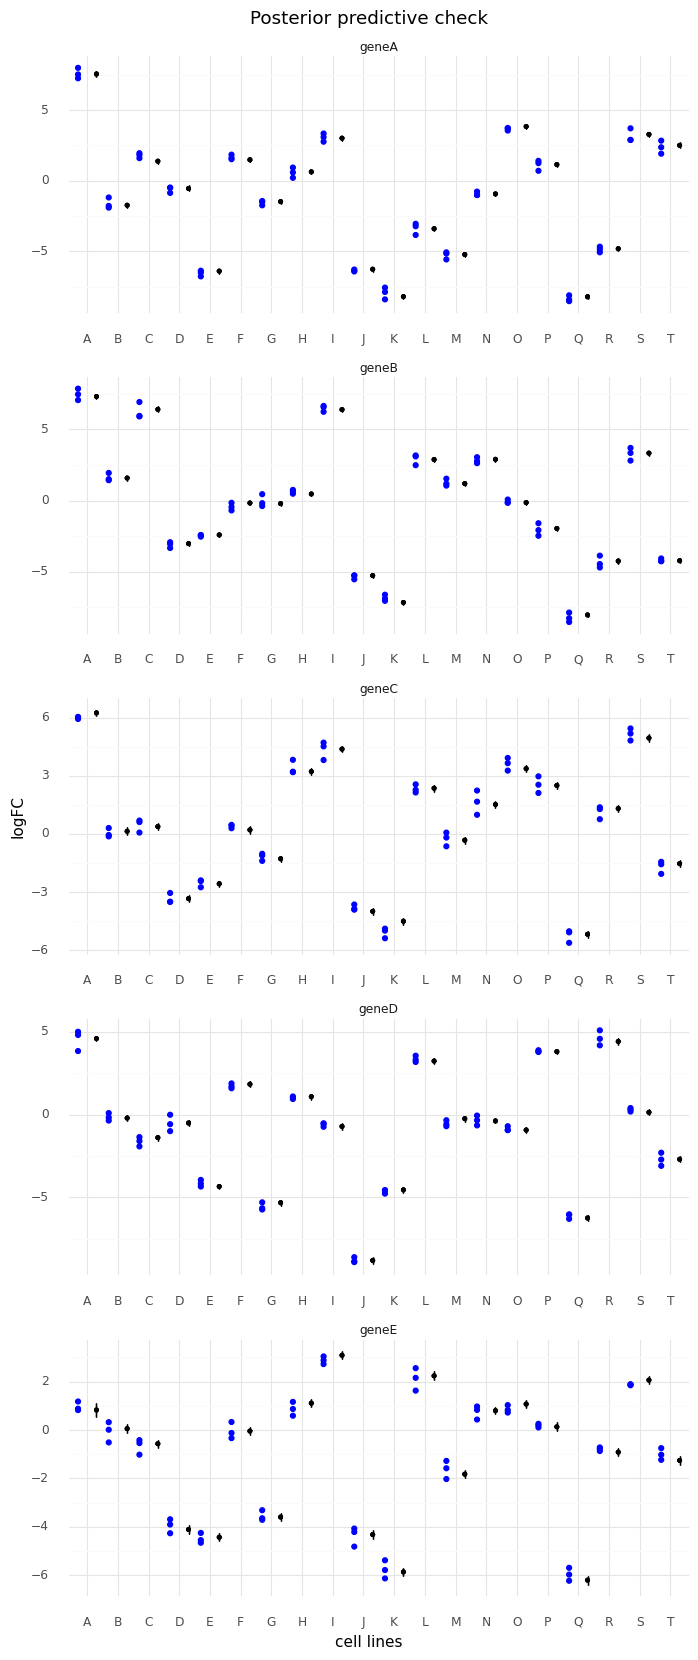

<ggplot: (8741716503269)>

In [22]:
(
    gg.ggplot(logfc_post_df, gg.aes(x="cell_line"))
    + gg.facet_wrap("gene", ncol=1, scales="free")
    + gg.geom_linerange(
        gg.aes(ymin="hpi_lower", ymax="hpi_upper"), position=gg.position_nudge(x=0.3)
    )
    + gg.geom_point(gg.aes(y="post_logfc"), position=gg.position_nudge(x=0.3), size=1)
    + gg.geom_point(gg.aes(y="logfc"), position=gg.position_nudge(x=-0.3), color="blue")
    + gg.scale_x_discrete(labels=[a.replace("cell", "") for a in cell_lines])
    + gg.theme(subplots_adjust={"hspace": 0.25, "wspace": 0.25}, figure_size=(8, 20))
    + gg.labs(x="cell lines", y="logFC", title="Posterior predictive check")
)

### Conclusions and final thoughts

The model fit well, as demonstrated by the final plot of the posterior predictions.
However, many of the variables' posterior distributions were very wide.
This indicates that there is multicolinearity between the predictors. 

---

In [23]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

numpy    1.19.2
seaborn  0.11.0
arviz    0.10.0
pymc3    3.9.3
plotnine 0.7.1
pandas   1.1.3
last updated: 2020-10-26 

CPython 3.8.5
IPython 7.18.1

compiler   : GCC 7.3.0
system     : Linux
release    : 3.10.0-1062.el7.x86_64
machine    : x86_64
processor  : x86_64
CPU cores  : 28
interpreter: 64bit
host name  : compute-e-16-237.o2.rc.hms.harvard.edu
Git branch : models
